用LSTM训练模型，一个视频中前80%时间序列用于训练，预测后20%时间序列(前10个时间步预测后一个，迭代实现)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Epoch 1, 训练损失: 0.1012, 验证损失: 0.0656
Epoch 2, 训练损失: 0.0236, 验证损失: 0.0146
Epoch 3, 训练损失: 0.0065, 验证损失: 0.0035
Epoch 4, 训练损失: 0.0023, 验证损失: 0.0026
Epoch 5, 训练损失: 0.0009, 验证损失: 0.0017
Epoch 6, 训练损失: 0.0005, 验证损失: 0.0013
Epoch 7, 训练损失: 0.0004, 验证损失: 0.0012
Epoch 8, 训练损失: 0.0003, 验证损失: 0.0011
Epoch 9, 训练损失: 0.0003, 验证损失: 0.0010
Epoch 10, 训练损失: 0.0002, 验证损失: 0.0009


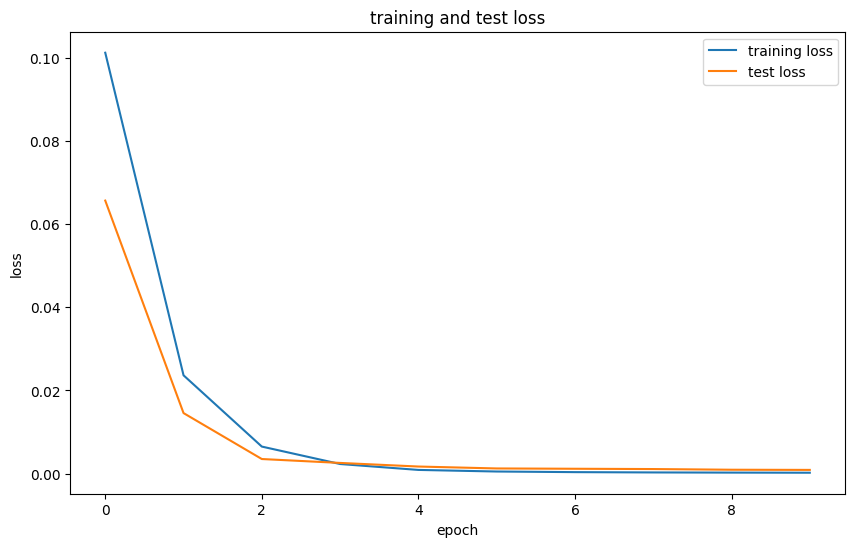

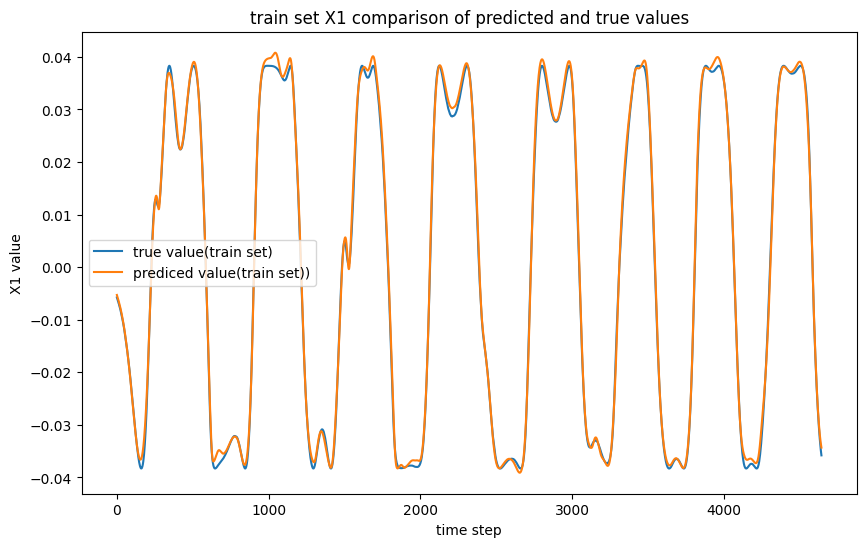

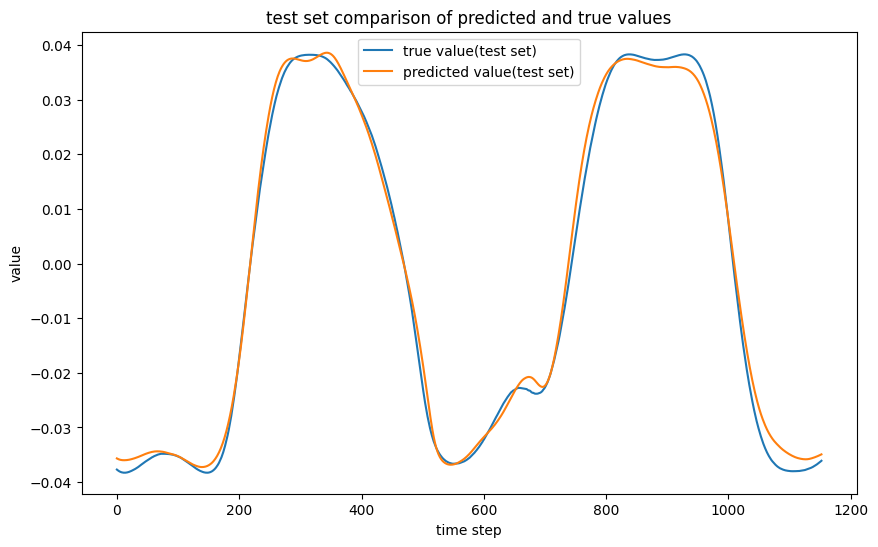

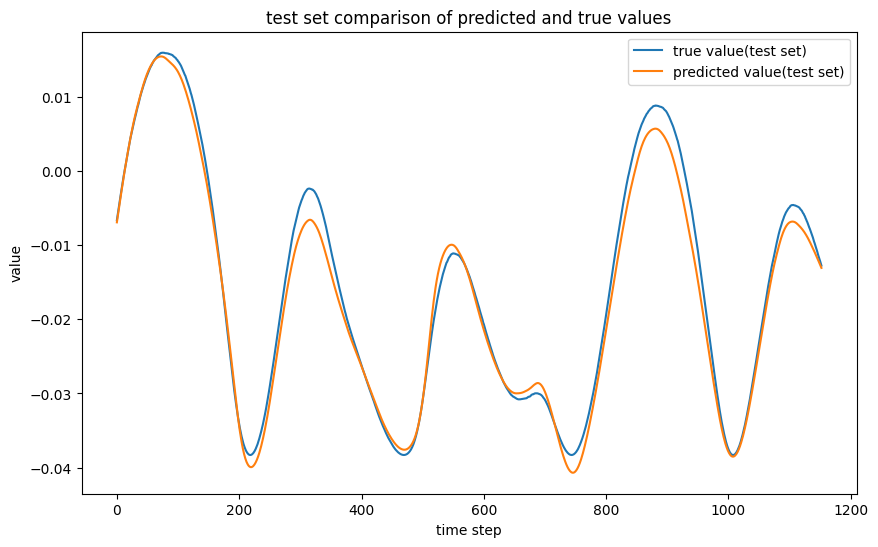

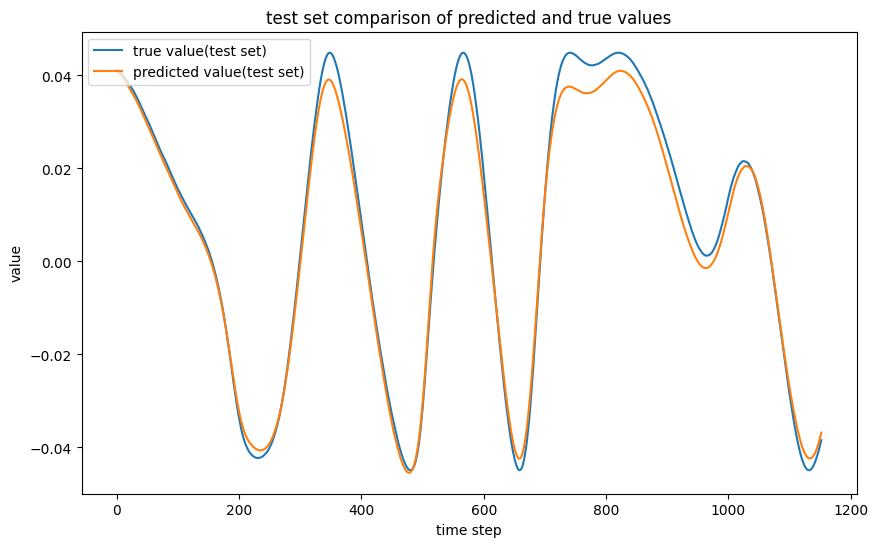

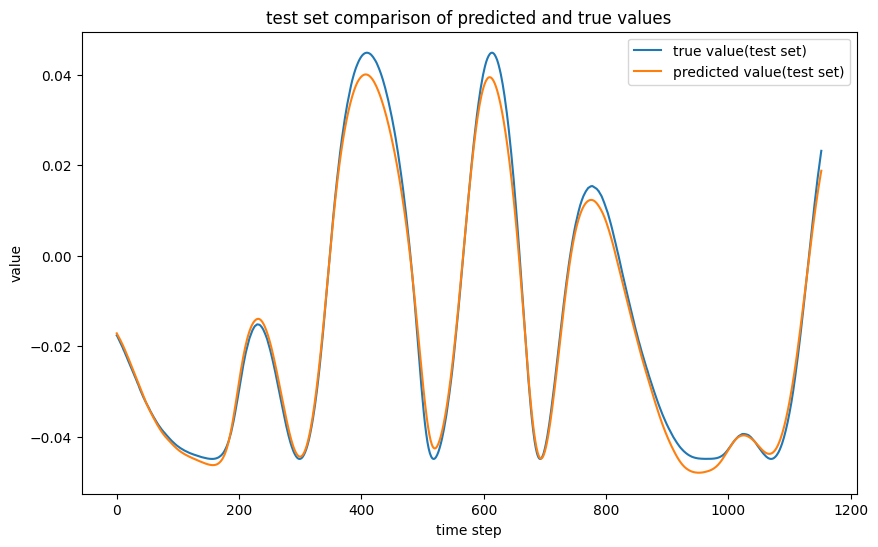

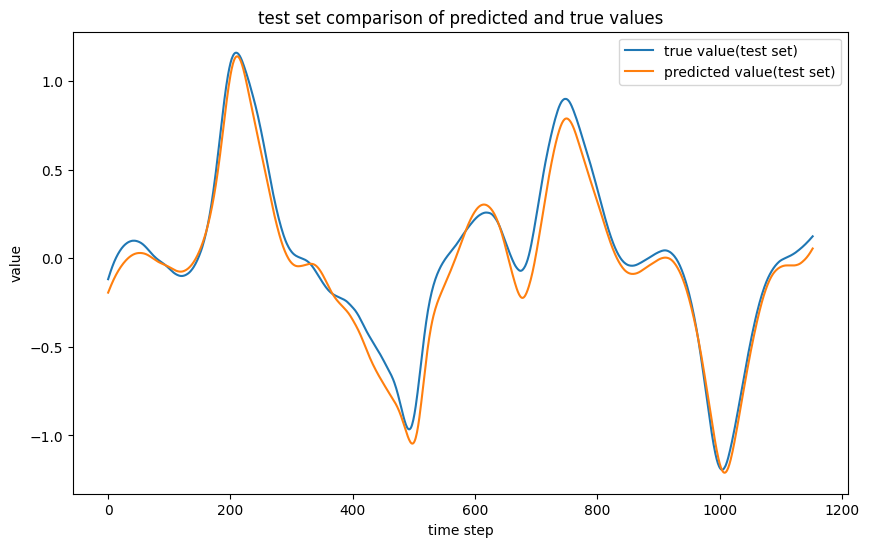

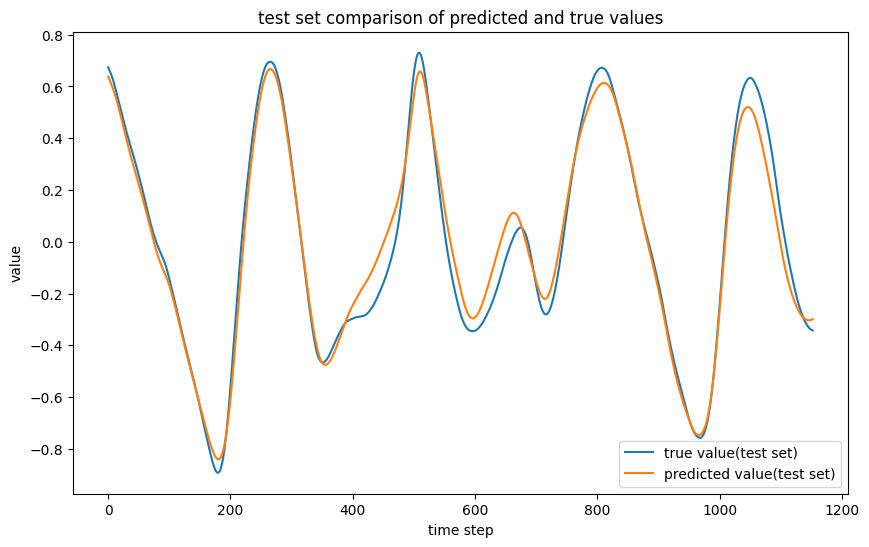

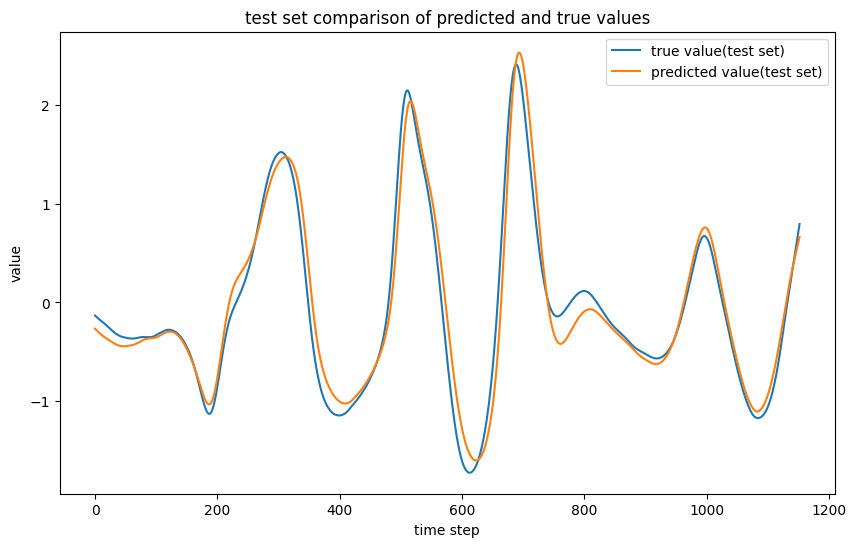

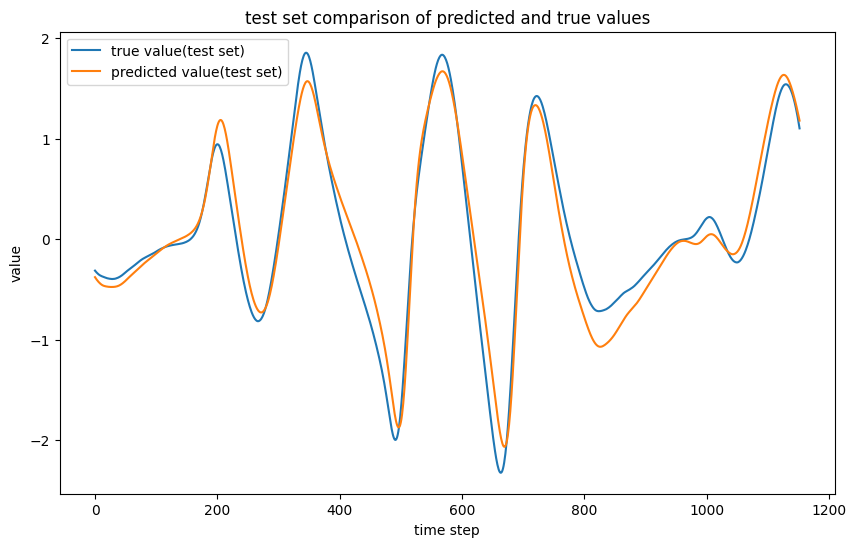

In [4]:
# 读取 Excel 文件
excel_file = pd.ExcelFile('test1-1.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('Sheet1')

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 50
output_size = y_train.shape[1]

model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
train_losses, val_losses = [], []
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='prediced value(train set))')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('X1 value')
plt.legend()
plt.show()

for i in range(1,9):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()


上面第3-10张图分别为x1,y1,x2,y2,vx1,vy1,vx2,vy2的预测值真实值对比

下面用theta1,theta2,omega1,omega2绘制相图，用PCA降维

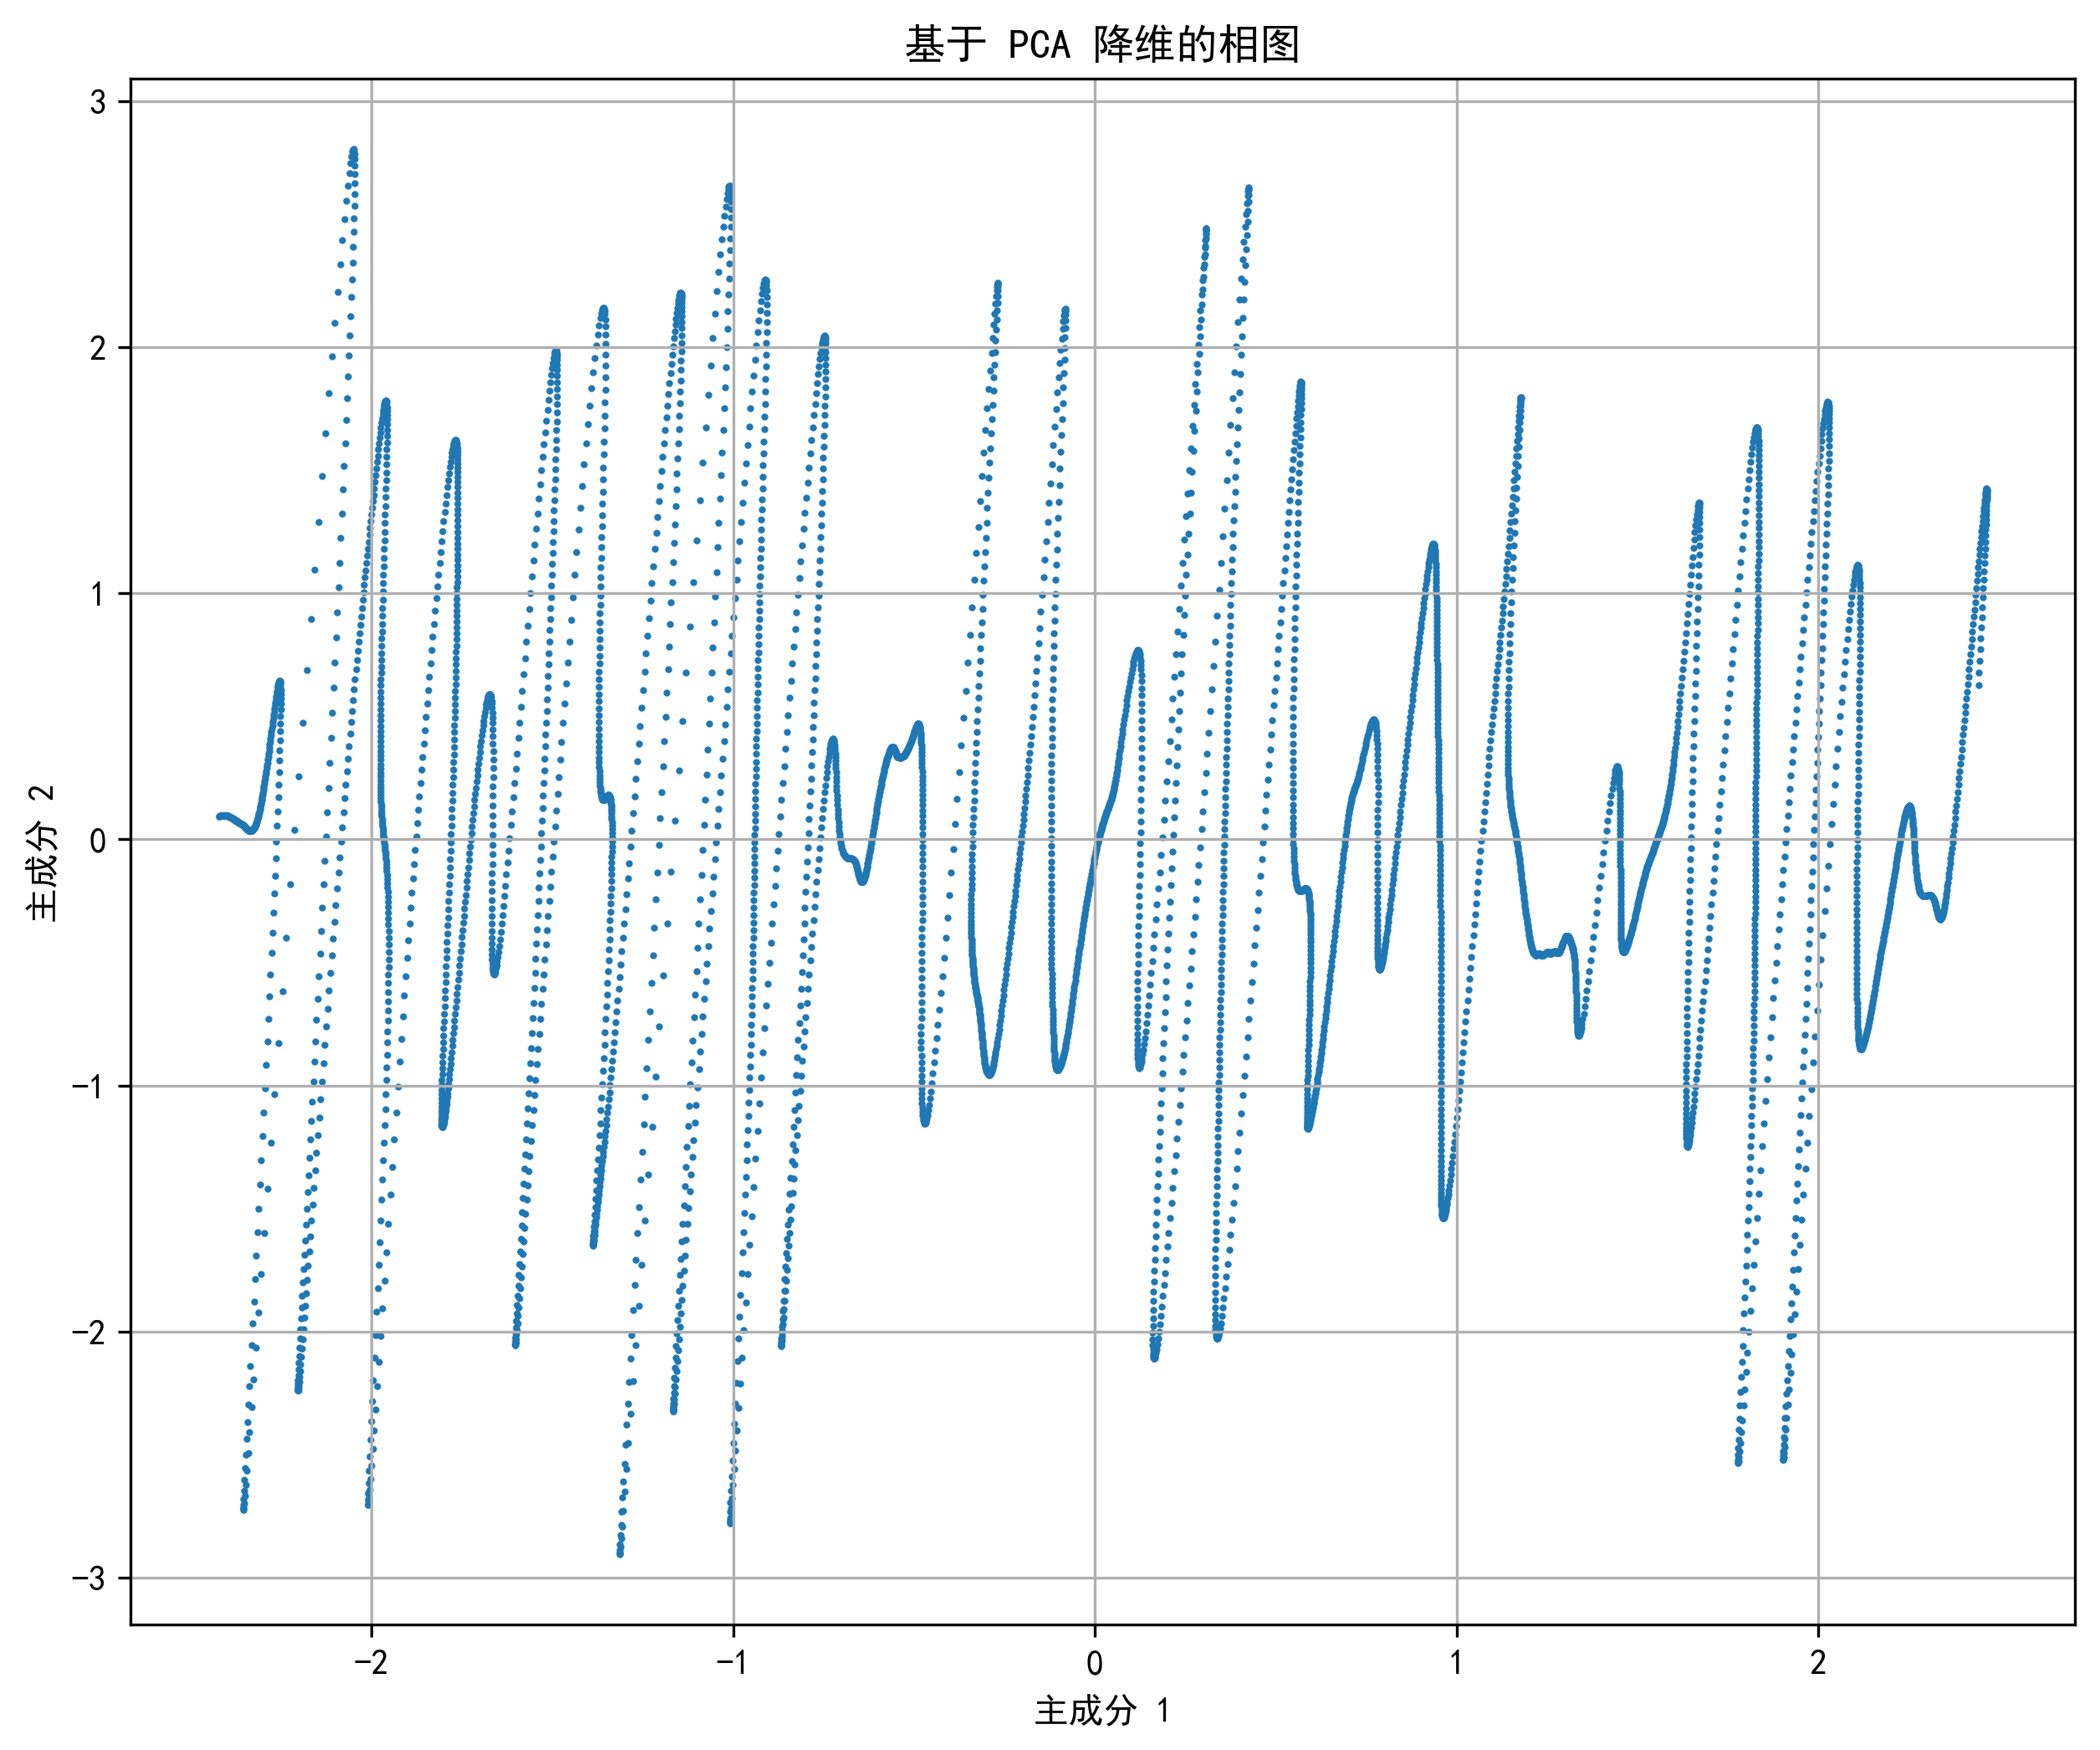

Lyapunov 指数: 0.0007836208239916493


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import numpy as np

plt.rcParams['font.family'] = 'SimHei'

# 使用 PCA 进行降维
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df)

# 绘制相图
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=1)
plt.title('基于 PCA 降维的相图')
plt.xlabel('主成分 1')
plt.ylabel('主成分 2')
plt.grid(True)
plt.show()

# 计算 Lyapunov 指数
def lyapunov_exponent(data, n_neighbors=20, tau=1, m=2):
    """
    计算 Lyapunov 指数。

    参数:
    data -- 输入数据 (numpy array)
    n_neighbors -- 最近邻的数量
    tau -- 时间延迟
    m -- 嵌入维度

    返回:
    平均 Lyapunov 指数
    """
    N = len(data)
    d0 = 1e-8  # 初始距离
    kdtree = KDTree(data)
    lyapunov_values = []

    for i in range(N - m * tau):
        point = data[i].reshape(1, -1)
        dist, ind = kdtree.query(point, k=n_neighbors + 1)
        neighbors = ind[0][1:]  # 排除自身

        for neighbor in neighbors:
            if i + m * tau < N and neighbor + m * tau < N:
                d1 = np.linalg.norm(data[i + m * tau] - data[neighbor + m * tau])
                d0_current = np.linalg.norm(data[i] - data[neighbor])
                if d0_current > 0:
                    lyapunov = (1 / (m * tau)) * np.log(d1 / d0_current)
                    lyapunov_values.append(lyapunov)

    if lyapunov_values:
        return np.mean(lyapunov_values)
    else:
        return 0

# 将数据转换为适合的格式
data = df.values

# 计算 Lyapunov 指数
lyapunov = lyapunov_exponent(data)
print(f'Lyapunov 指数: {lyapunov}')

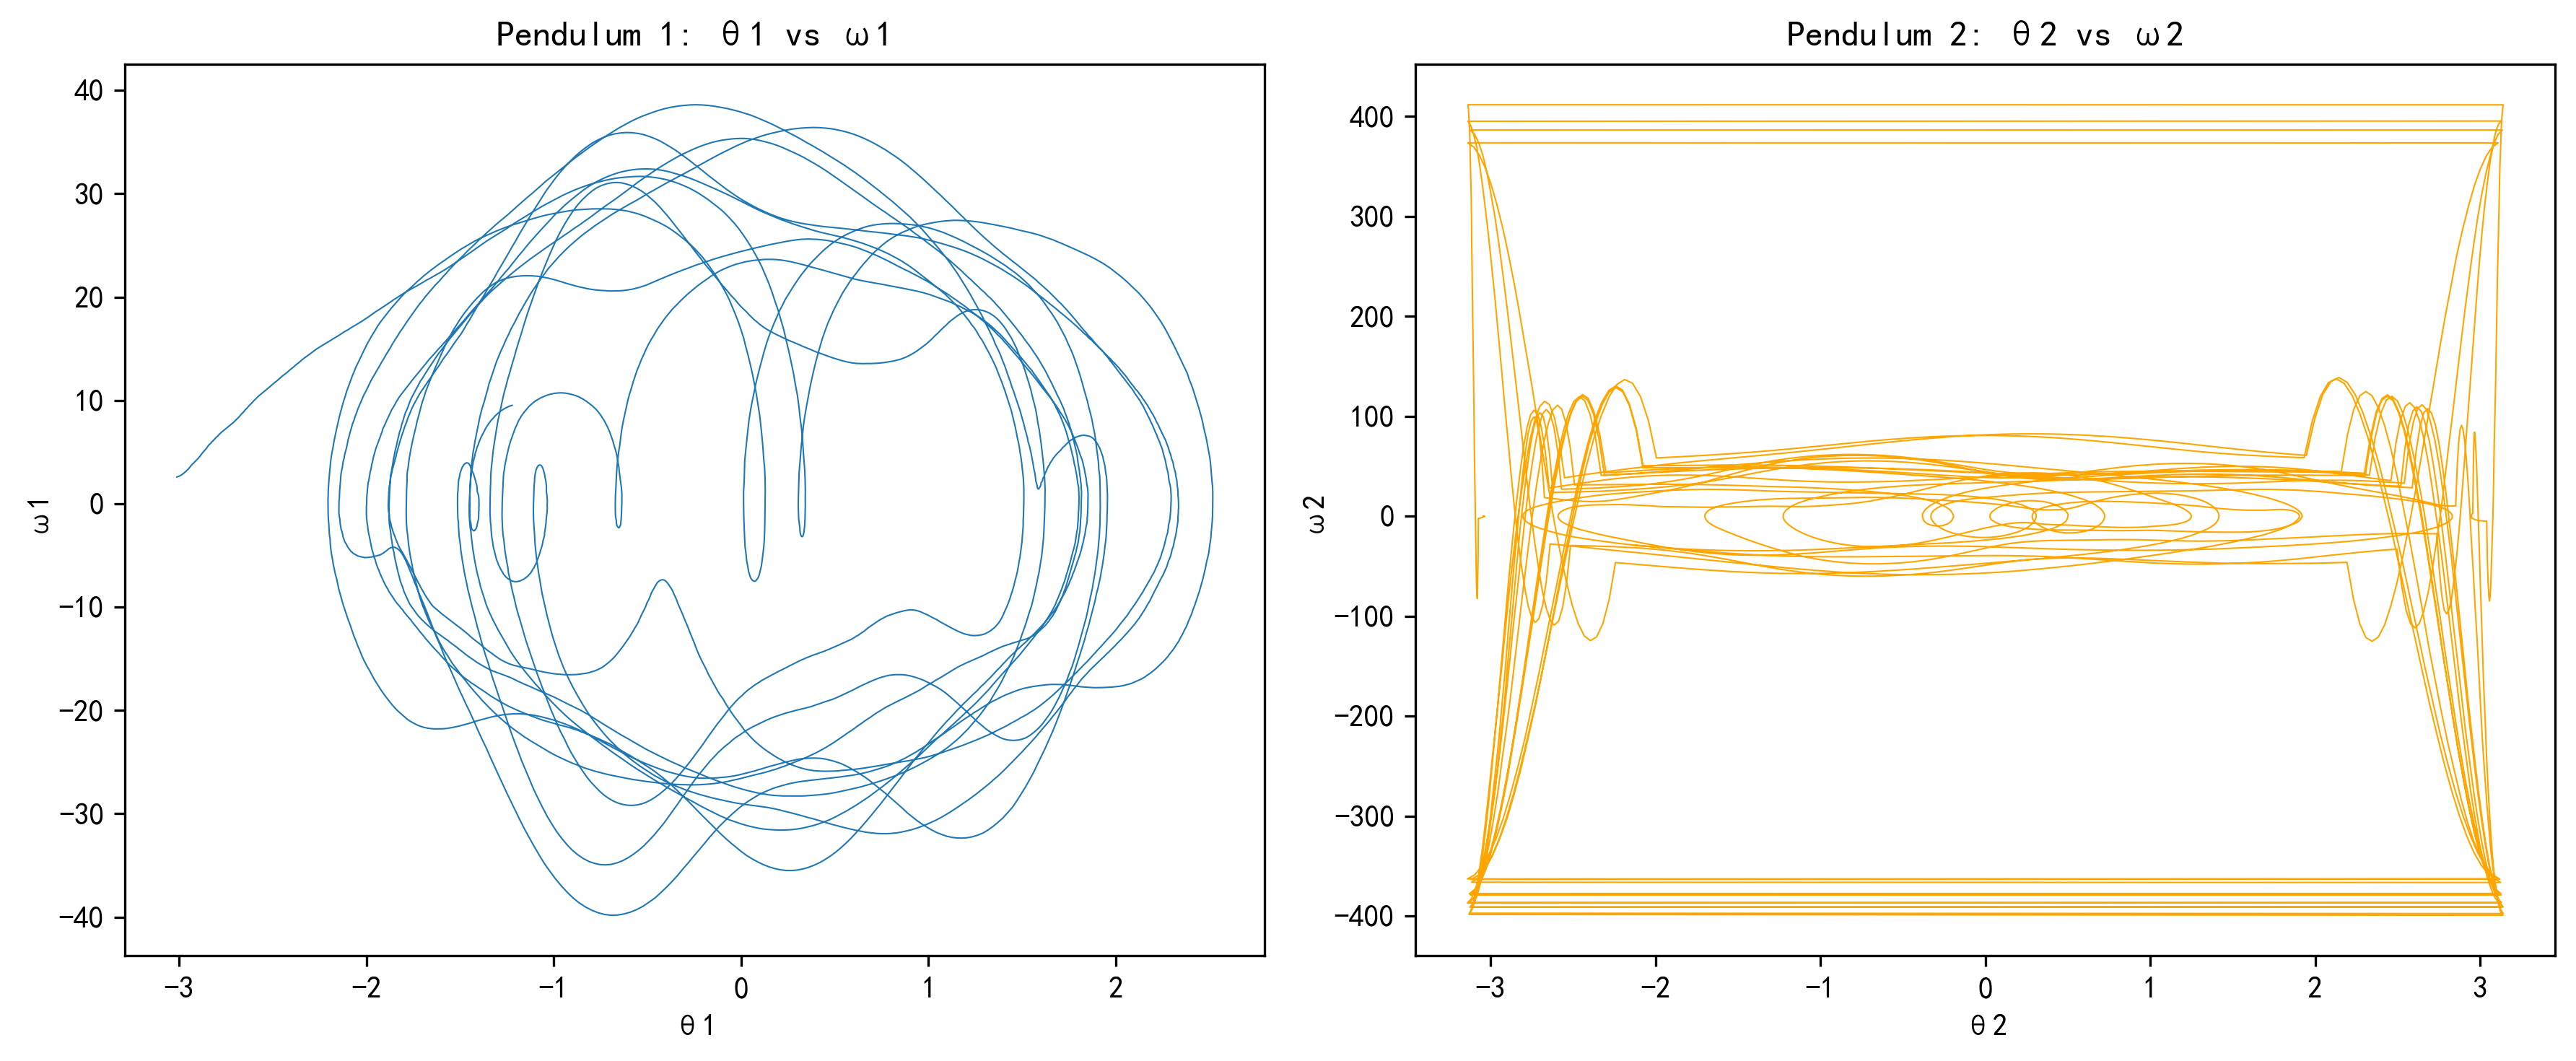

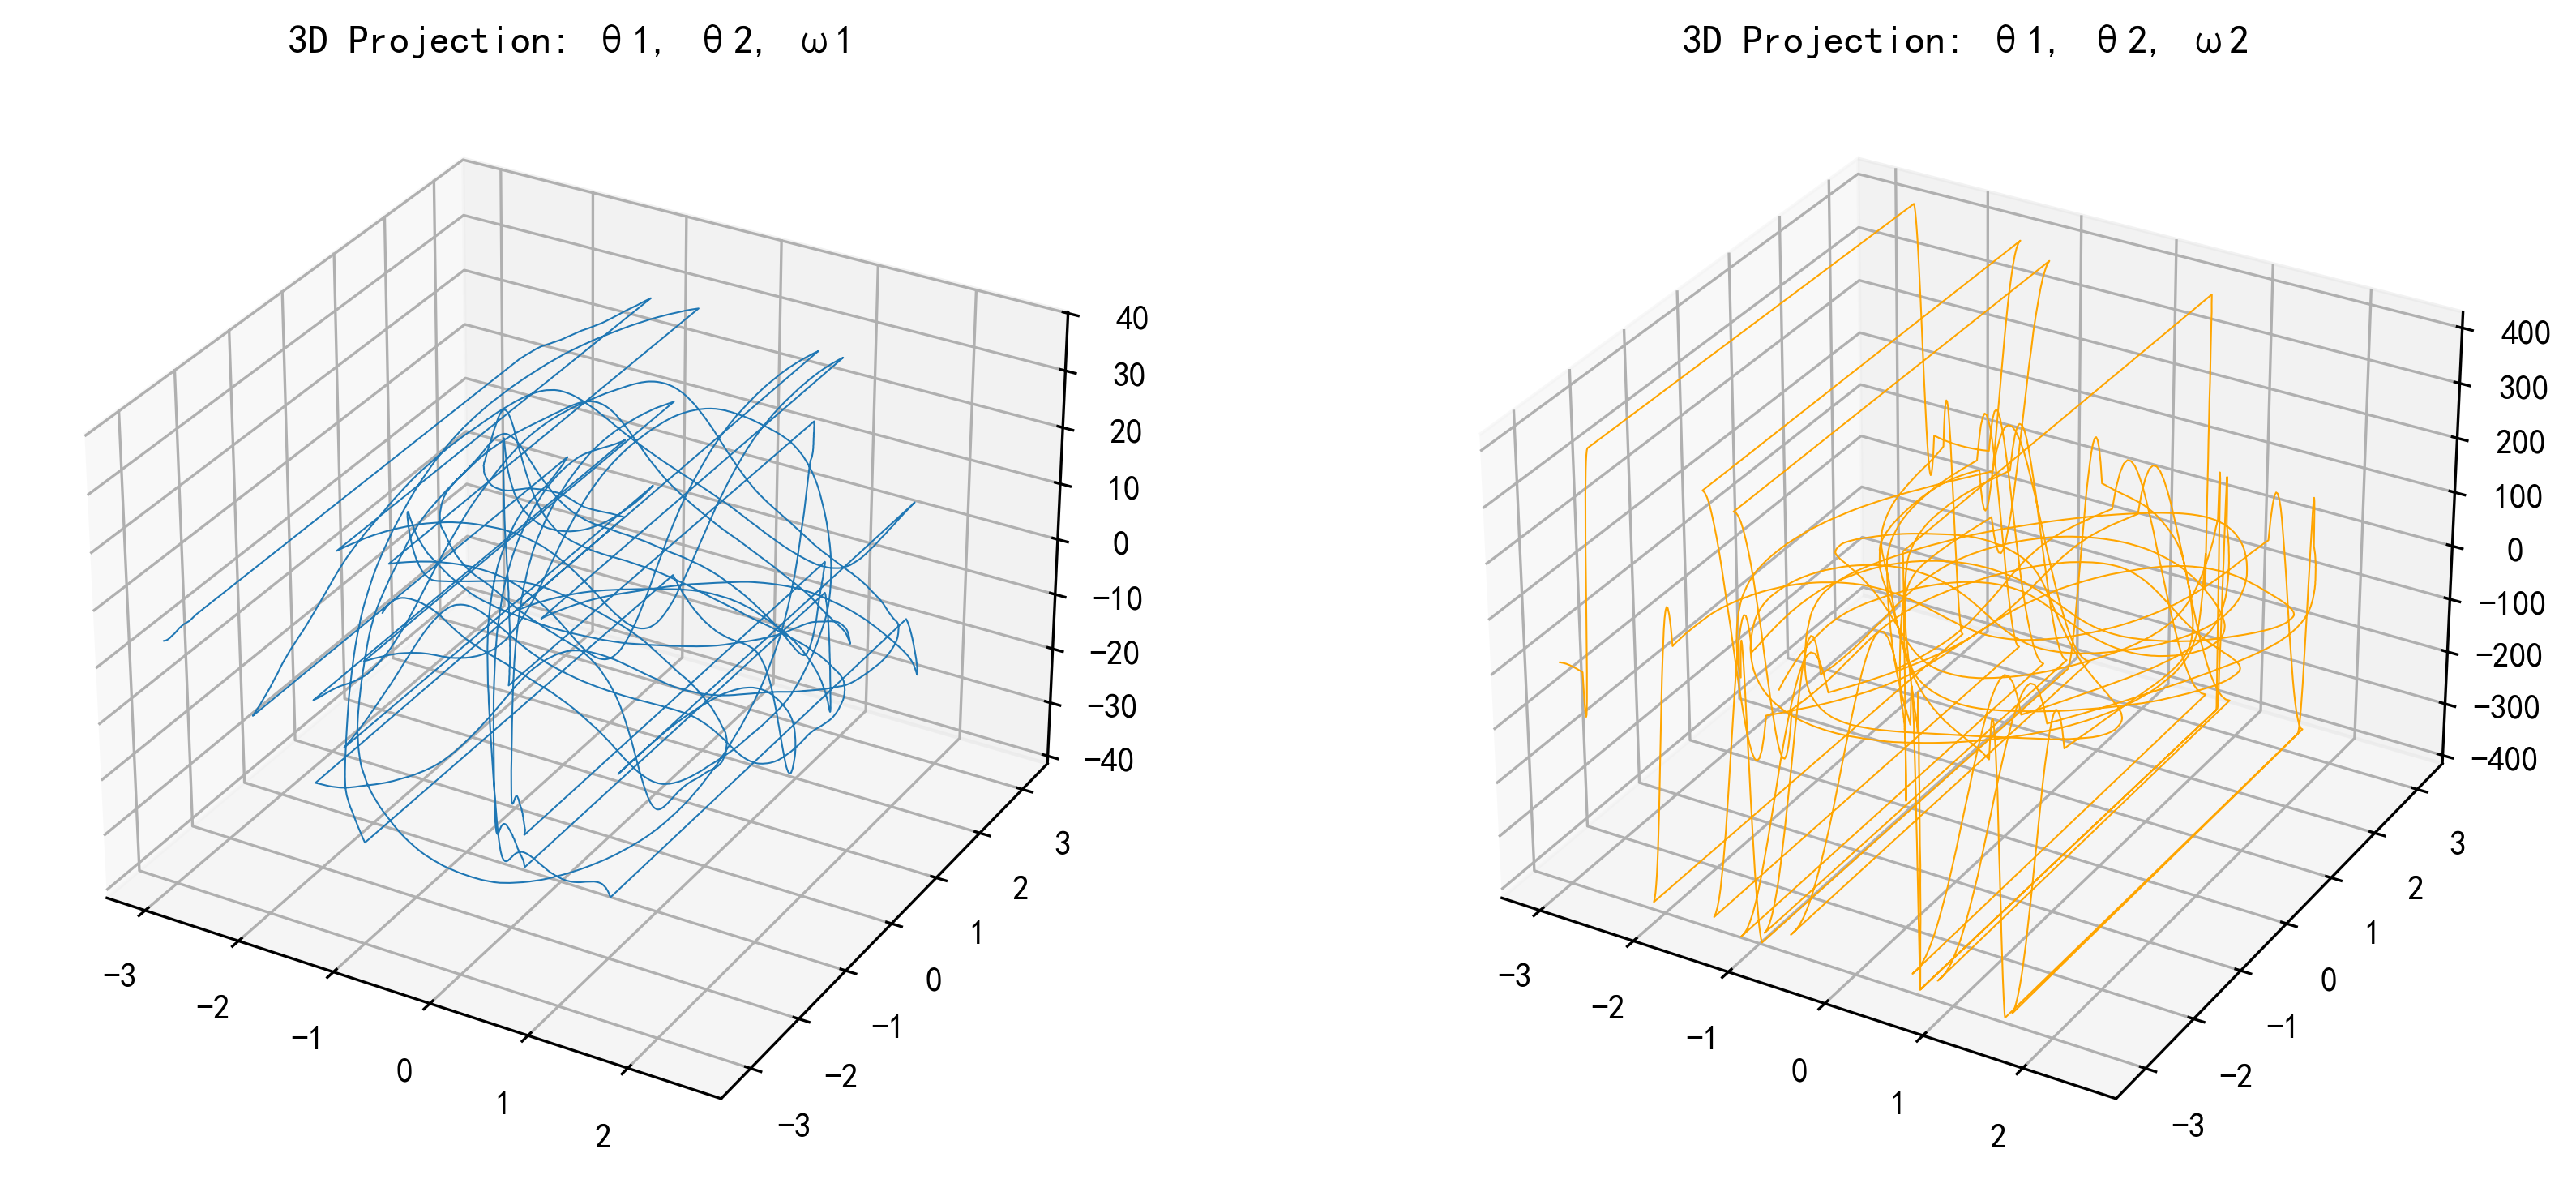

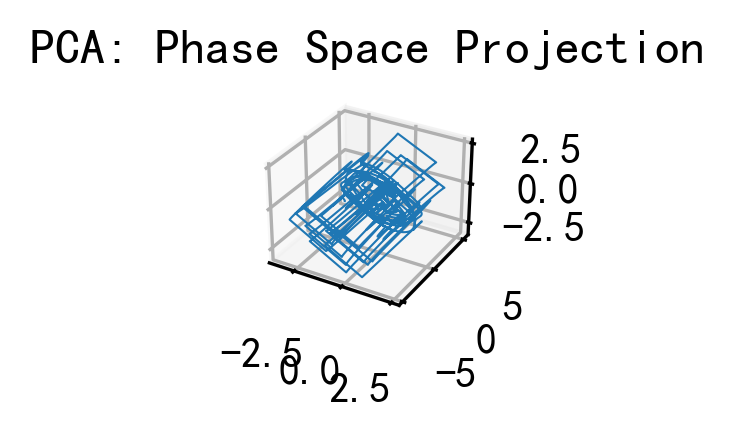

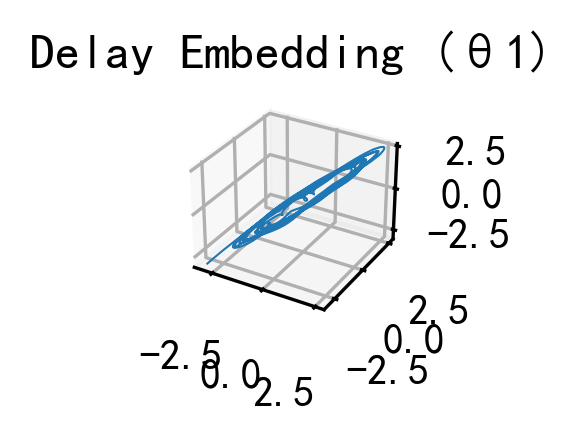

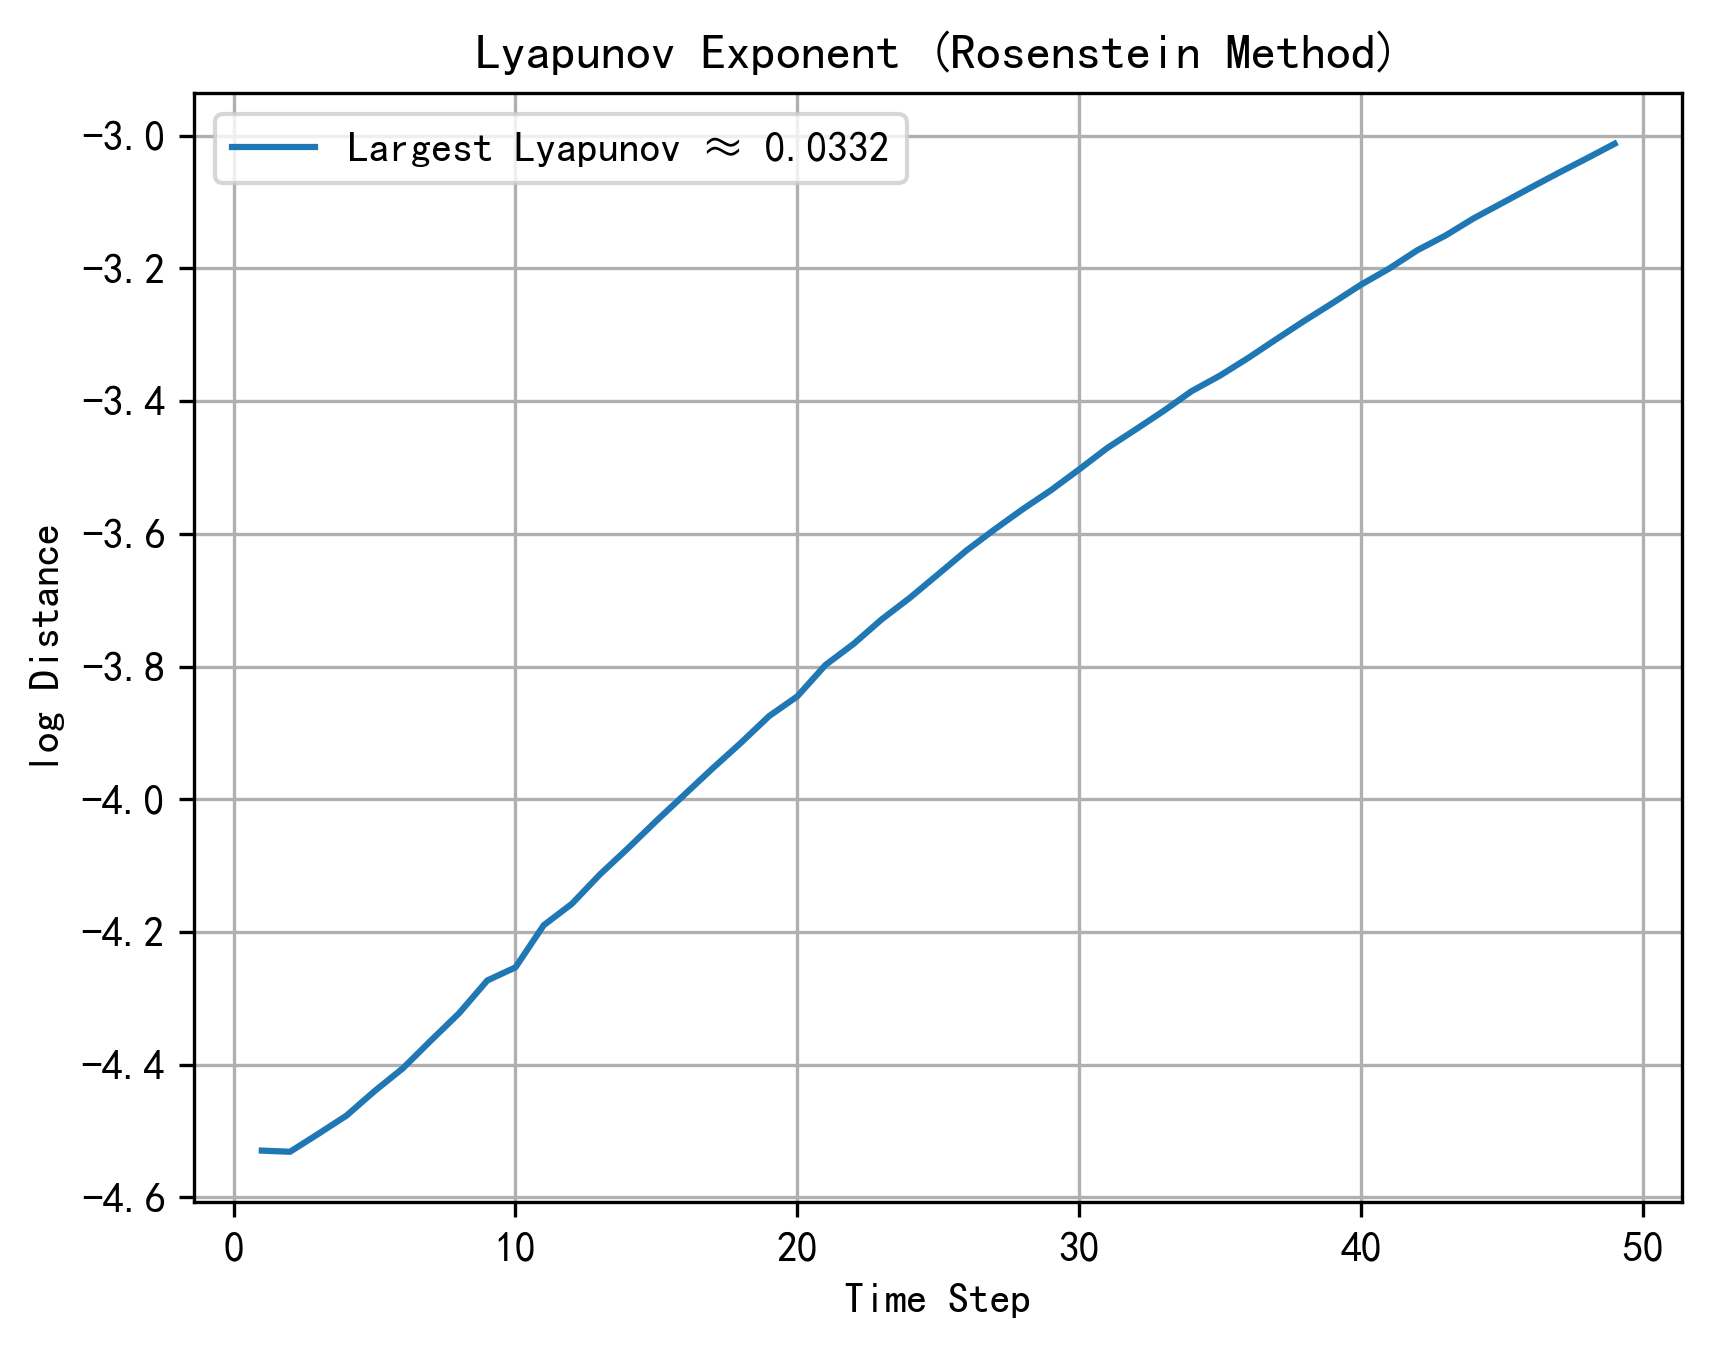

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
import torch

plt.rcParams['font.family'] = 'SimHei'

# 读取并清洗数据
file_path = 'test1-1theta.xlsx'
df = pd.read_excel(file_path, header=None)
df.columns = ['theta1', 'theta2', 'omega1', 'omega2']
df = df.drop(index=0).reset_index(drop=True).astype(float)

# 相图与三维投影
data = torch.tensor(df.values, dtype=torch.float32)
theta1, theta2, omega1, omega2 = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

# 相图
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(theta1, omega1, lw=0.5)
axs[0].set_title('Pendulum 1: θ1 vs ω1')
axs[0].set_xlabel('θ1'); axs[0].set_ylabel('ω1')
axs[1].plot(theta2, omega2, lw=0.5, color='orange')
axs[1].set_title('Pendulum 2: θ2 vs ω2')
axs[1].set_xlabel('θ2'); axs[1].set_ylabel('ω2')
plt.tight_layout(); plt.show()

# 三维投影
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(theta1, theta2, omega1, lw=0.5)
ax1.set_title('3D Projection: θ1, θ2, ω1')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(theta1, theta2, omega2, lw=0.5, color='orange')
ax2.set_title('3D Projection: θ1, θ2, ω2')
plt.tight_layout(); plt.show()

# PCA 主成分分析
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.values)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

fig = plt.figure(figsize=(1, 1))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], lw=0.5)
ax.set_title('PCA: Phase Space Projection')
plt.show()

# 延迟嵌入法
def delay_embedding(series, dim=3, tau=10):
    N = len(series) - (dim - 1) * tau
    return np.array([series[i:i + dim * tau:tau] for i in range(N)])

theta1_np = theta1.numpy()
embedded = delay_embedding(theta1_np, dim=3, tau=10)

fig = plt.figure(figsize=(1, 1))
ax = fig.add_subplot(111, projection='3d')
ax.plot(embedded[:, 0], embedded[:, 1], embedded[:, 2], lw=0.5)
ax.set_title('Delay Embedding (θ1)')
plt.show()

# 最大 Lyapunov 指数（Rosenstein 方法）
def max_lyapunov(ex_data, tau=1, max_t=50):
    N = len(ex_data)
    d = np.zeros((N, max_t))
    eps = 1e-9

    for i in range(N - max_t):
        # 找最近邻，距离>eps 且时间间隔>50
        distances = norm(ex_data - ex_data[i], axis=1)
        distances[i] = np.inf
        j = np.argmin(distances)

        # 时序跟踪
        for k in range(max_t):
            if i + k < N and j + k < N:
                d[i, k] = norm(ex_data[i + k] - ex_data[j + k]) + eps

    d = np.log(d + eps)
    mean_d = np.mean(d, axis=0)
    return mean_d

lyap_curve = max_lyapunov(embedded, max_t=50)

# 拟合斜率（Lyapunov 指数）
from scipy.stats import linregress
t = np.arange(1, 50)
slope, _, _, _, _ = linregress(t, lyap_curve[1:])

plt.plot(t, lyap_curve[1:], label=f"Largest Lyapunov ≈ {slope:.4f}")
plt.xlabel("Time Step")
plt.ylabel("log Distance")
plt.title("Lyapunov Exponent (Rosenstein Method)")
plt.legend()
plt.grid(True)
plt.show()


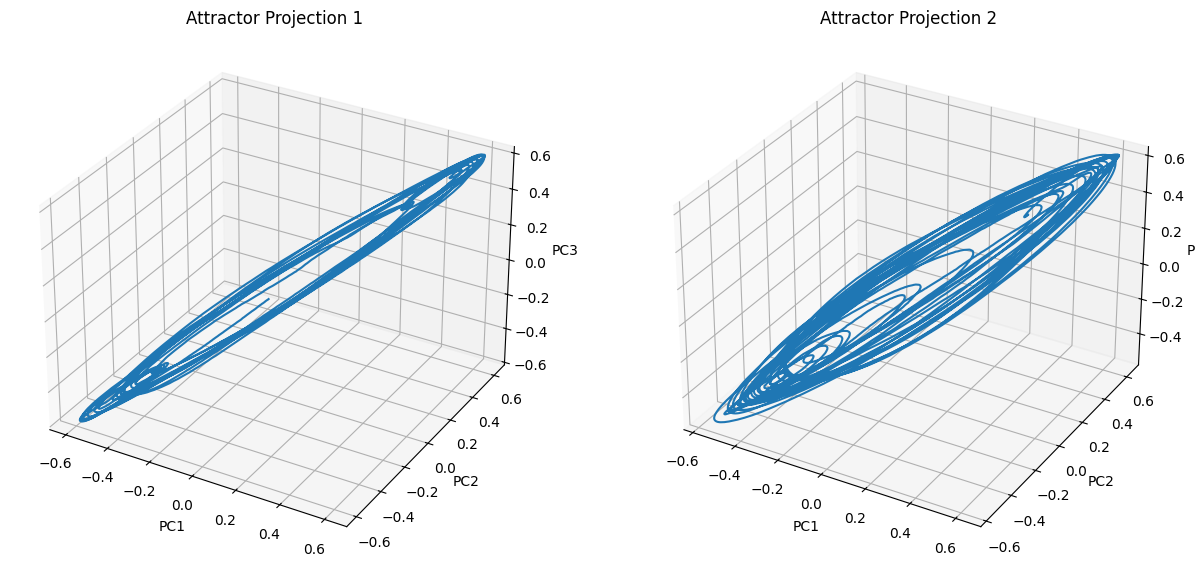

Lyapunov Exponents for Projection 1: [0.01243627 0.02306356 0.        ]
Lyapunov Exponents for Projection 2: [0.0286159  0.13355764 0.        ]


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.linalg import norm
import warnings
warnings.filterwarnings("ignore")

# 1. 数据准备
new_excel_file = pd.ExcelFile('test1-1.xlsx')
new_df = new_excel_file.parse('Sheet1')  # 请替换为实际的工作表名


phase_space_data = new_df.iloc[:, 1:5].values

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
phase_space_data = scaler.fit_transform(phase_space_data)

# 2. 选择三维投影
# 选择两个不同的三维组合
projection1 = phase_space_data[:, [0, 1, 2]]
projection2 = phase_space_data[:, [1, 2, 3]]

# 3. PCA（主成分分析）
pca1 = PCA(n_components=3)
pca_projection1 = pca1.fit_transform(projection1)

pca2 = PCA(n_components=3)
pca_projection2 = pca2.fit_transform(projection2)

# 4. 延迟嵌入
def delay_embedding(data, delay, dimension):
    """
    使用延迟嵌入方法将时间序列数据嵌入到相空间中
    :param data: 时间序列数据
    :param delay: 延迟时间
    :param dimension: 嵌入维度
    :return: 嵌入后的相空间数据
    """
    embedded_data = []
    for i in range(len(data) - (dimension - 1) * delay):
        embedded_data.append(data[i:i + (dimension - 1) * delay + 1:delay])
    return np.array(embedded_data)

# 假设延迟时间为5，嵌入维度为3
delay = 5
dimension = 3

embedded_projection1 = delay_embedding(pca_projection1[:, 0], delay, dimension)
embedded_projection2 = delay_embedding(pca_projection2[:, 0], delay, dimension)

# 5. 可视化吸引子
fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(embedded_projection1[:, 0], embedded_projection1[:, 1], embedded_projection1[:, 2])
ax1.set_title('Attractor Projection 1')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(embedded_projection2[:, 0], embedded_projection2[:, 1], embedded_projection2[:, 2])
ax2.set_title('Attractor Projection 2')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

plt.show()

# 6. 计算劳氏系数
def lyapunov_exponents(data, delay, dimension, num_iterations=100):
    """
    计算劳氏系数
    :param data: 时间序列数据
    :param delay: 延迟时间
    :param dimension: 嵌入维度
    :param num_iterations: 迭代次数
    :return: 劳氏系数
    """
    embedded_data = delay_embedding(data, delay, dimension)
    n = len(embedded_data)
    lambda_vec = np.zeros(dimension)

    for i in range(num_iterations):
        if i >= n - 1:
            break
        x = embedded_data[i]
        y = x.copy()
        e = np.random.normal(0, 0.001, dimension)
        y = y + e
        indices = np.arange(i + 1, n)
        dists = np.array([norm(y - embedded_data[j]) for j in indices])
        min_index = indices[np.argmin(dists)]
        y = embedded_data[min_index]

        d0 = norm(x - y)
        for k in range(1, dimension):
            xk = embedded_data[i + k]
            yk = embedded_data[min_index + k]
            dk = norm(xk - yk)
            lambda_vec[k - 1] += np.log(dk / d0)

    lambda_vec = lambda_vec / num_iterations
    return lambda_vec

lyapunov1 = lyapunov_exponents(pca_projection1[:, 0], delay, dimension)
lyapunov2 = lyapunov_exponents(pca_projection2[:, 0], delay, dimension)

print("Lyapunov Exponents for Projection 1:", lyapunov1)
print("Lyapunov Exponents for Projection 2:", lyapunov2)

混沌摆是一个典型的混沌系统，其运动轨迹对初始条件非常敏感，表现出看似随机的行为。混沌摆的吸引子是指在相空间中，系统的运动轨迹最终会趋向于的一个复杂的几何结构。这个结构通常是分形的，具有自相似性和无限细节。吸引子描述了系统在长时间内的行为模式，尽管混沌摆的运动看起来是随机的，但实际上它被吸引子所约束，不会离开吸引子所在的区域。
PCA 是一种降维技术，它通过线性变换将原始的高维数据转换为一组新的正交变量，称为主成分。这些主成分按照方差从大到小排列，方差越大表示该主成分包含的原始数据信息越多。在四维相空间中使用 PCA 可以将数据降维到较低维度（如三维或二维），以便于可视化和分析，同时尽可能保留数据的主要特征和变化趋势。
延迟嵌入是一种用于处理时间序列数据的技术，它通过将时间序列在不同时间延迟下的取值组合成高维空间中的向量。这种方法的理论基础是 Takens 定理，该定理表明，只要时间序列足够长，并且选择合适的延迟时间和嵌入维度，即使仅通过单个观测变量的时间序列，也能在多维相空间中重构出与原系统动力学等价的结构，为从时间序列数据恢复系统全貌提供了理论保障。在混沌系统中，延迟嵌入可以帮助我们将时间序列数据映射到相空间中，从而揭示系统的吸引子结构。
为什么这样就能画出吸引子呢？
吸引子是指在动力系统中，随着时间的推移，系统的状态会趋向于的一个集合。在混沌系统中，吸引子通常具有复杂的几何结构，如分形。PCA 通过降维保留了数据的主要变化模式，而延迟嵌入则将时间序列数据映射到相空间中，使得系统的动力学行为在相空间中得以体现。通过这两种方法的结合，我们可以在较低维度的相空间中观察到系统的吸引子结构，因为吸引子是系统动力学的核心特征，即使在降维后仍然能够被捕捉到。

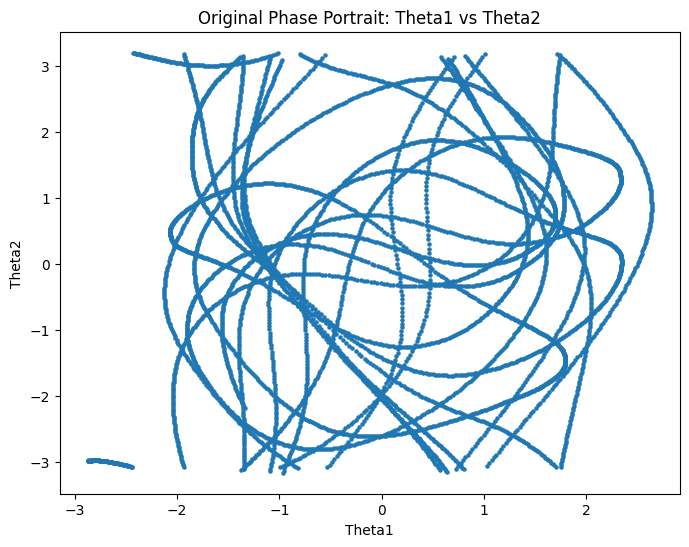

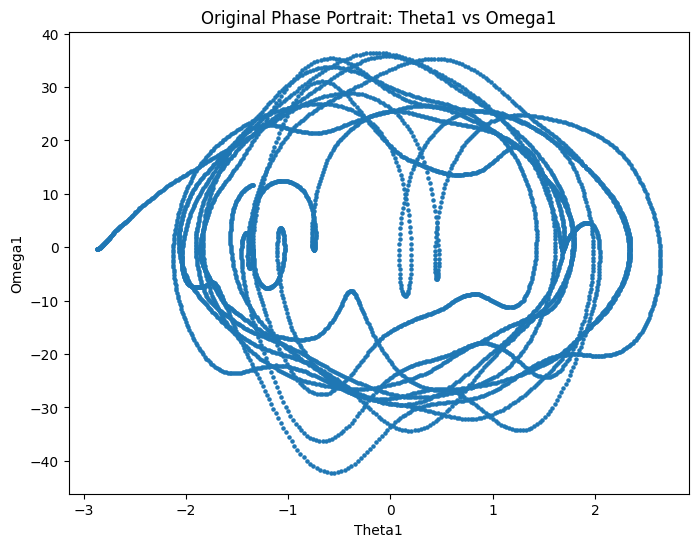

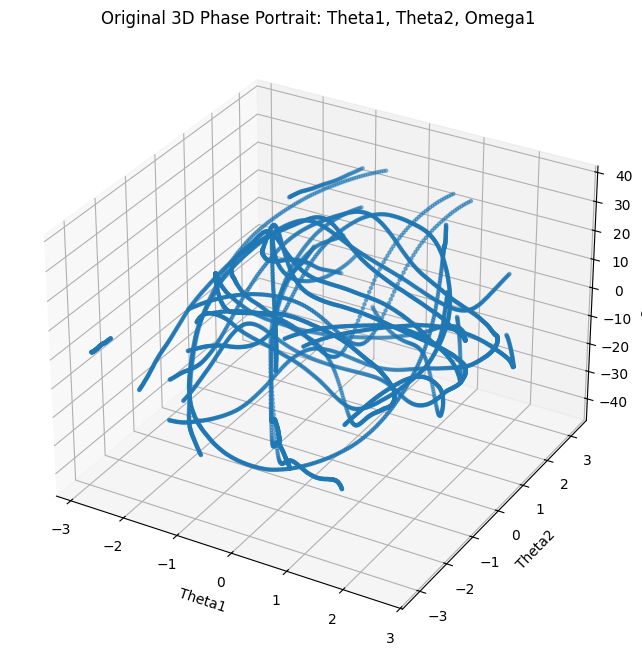

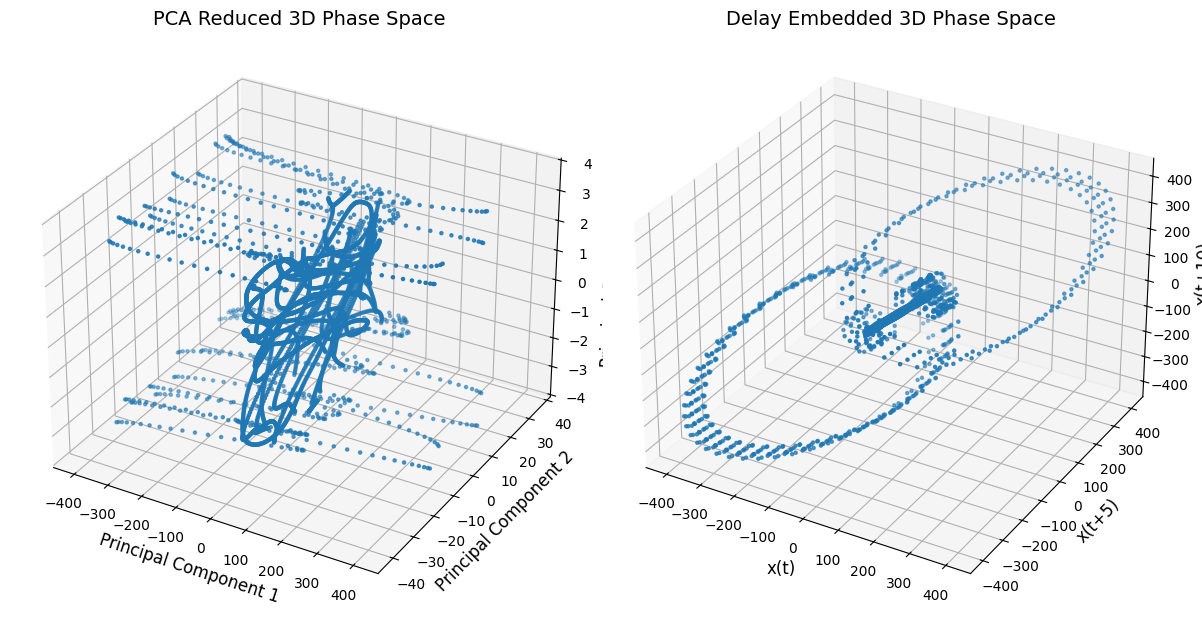

Lyapunov Exponents: [-0.97213807 -0.97037038 -0.9680634 ]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.signal import detrend

# 读取数据
df = pd.read_excel('test1-1theta.xlsx')

# 提取相空间的四个参数（去掉时间列）
data = df.iloc[:, 1:5].values

# 对数据进行去趋势处理
data = detrend(data, axis=0)

# 绘制原始的二维相图
# theta1 vs theta2
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], s=5)
plt.title('Original Phase Portrait: Theta1 vs Theta2')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.show()

# theta1 vs omega1
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 2], s=5)
plt.title('Original Phase Portrait: Theta1 vs Omega1')
plt.xlabel('Theta1')
plt.ylabel('Omega1')
plt.show()

# 绘制原始的三维相图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=5)
ax.set_title('Original 3D Phase Portrait: Theta1, Theta2, Omega1')
ax.set_xlabel('Theta1')
ax.set_ylabel('Theta2')
ax.set_zlabel('Omega1')
plt.show()

# 使用PCA进行降维到三维
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data)

# 延迟嵌入函数
def delay_embedding(time_series, delay, dimension):
    embedded = []
    for i in range(len(time_series) - (dimension - 1) * delay):
        embed = []
        for j in range(dimension):
            embed.append(time_series[i + j * delay])
        embedded.append(embed)
    return np.array(embedded)

# 选择一个参数进行延迟嵌入（这里选择第一个角度 theta1）
time_series = pca_data[:, 0]
delay = 5  # 延迟参数
dimension = 3  # 嵌入维数
embedded_data = delay_embedding(time_series, delay, dimension)

# 绘制三维相空间投影
fig = plt.figure(figsize=(12, 10))

# 绘制PCA降维后的三维相空间
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], s=5)
ax1.set_title('PCA Reduced 3D Phase Space', fontsize=14)
ax1.set_xlabel('Principal Component 1', fontsize=12)
ax1.set_ylabel('Principal Component 2', fontsize=12)
ax1.set_zlabel('Principal Component 3', fontsize=12)

# 绘制延迟嵌入后的三维相空间
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], s=5)
ax2.set_title('Delay Embedded 3D Phase Space', fontsize=14)
ax2.set_xlabel('x(t)', fontsize=12)
ax2.set_ylabel('x(t+{})'.format(delay), fontsize=12)
ax2.set_zlabel('x(t+{})'.format(2 * delay), fontsize=12)

plt.tight_layout()
plt.show()

# 计算劳氏系数（Lyapunov Exponents）评估混沌程度
# 这里使用Wolf算法的简单实现，实际应用中可能需要更精确的方法
def lyapunov_exponents(data, max_iter=1000, epsilon=1e-10):
    n, d = data.shape
    exponents = np.zeros(d)
    for i in range(d):
        trajectory = data[:, i].reshape(-1, 1)
        length = len(trajectory)
        distances = np.linalg.norm(trajectory[1:] - trajectory[:-1], axis=1)
        exponents[i] = np.sum(np.log(distances + epsilon)) / (length - 1)
    return exponents

lyapunovs = lyapunov_exponents(embedded_data)
print("Lyapunov Exponents:", lyapunovs)

Lyapunov Exponents 用于衡量动力系统中相邻轨迹的平均指数分离率 ，常见计算方法有以下几种：
Wolf 算法:
从时间序列数据中重构相空间（如使用延迟嵌入法），得到一系列相空间中的点。选择一个初始点及其附近的一个小邻域（如选取距离初始点最近的点）。
随着时间步长推进，跟踪这两个点的演化，计算它们之间距离的变化。对多个初始点重复上述过程，并对距离变化取对数平均，得到李雅普诺夫指数。
小数据量法:
同样先对时间序列进行相空间重构。针对相空间中的每个点，寻找其最邻近点。计算这些点对在后续时间步长中距离的演化，根据特定公式计算李雅普诺夫指数。


尝试多变量延迟嵌入

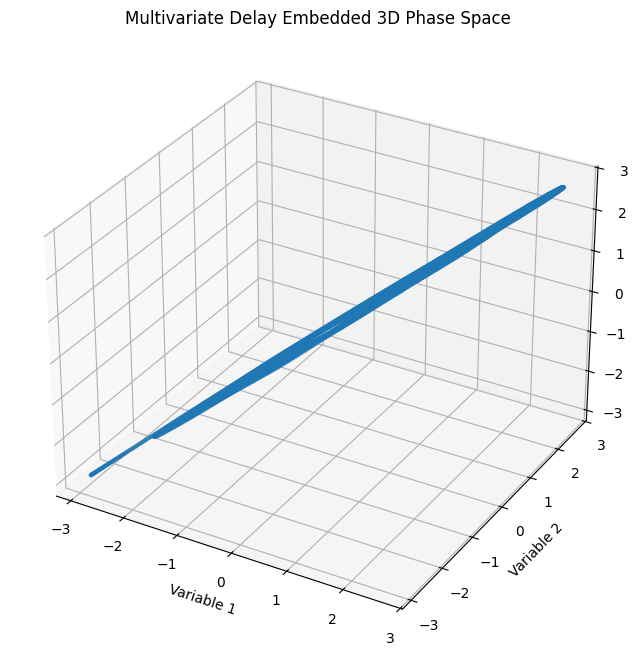

Lyapunov Exponents: [-4.6951522  -4.69455909 -4.6941979  -4.06824618 -4.06723018 -4.06612173
 -1.64750737 -1.64692145 -1.64651633 -0.97612146 -0.97537896 -0.97456648]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.signal import detrend


# 读取数据
df = pd.read_excel('test1-1theta.xlsx')

# 提取相空间的四个参数（去掉时间列）
data = df.iloc[:, 1:5].values

# 对数据进行去趋势处理
data = detrend(data, axis=0)

# 多变量延迟嵌入函数
def multivariate_delay_embedding(data, delays, dimension):
    num_vars = data.shape[1]
    num_points = len(data) - (dimension - 1) * max(delays)
    embedded = []
    for i in range(num_points):
        embed = []
        for var in range(num_vars):
            for j in range(dimension):
                embed.append(data[i + j * delays[var], var])
        embedded.append(embed)
    return np.array(embedded)

# 这里假设每个变量的延迟时间
delays = [2, 2, 2, 2]
dimension = 3

# 进行多变量延迟嵌入
embedded_data = multivariate_delay_embedding(data, delays, dimension)

# 绘制延迟嵌入后的三维相空间（这里选取前三个变量作为示例）
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], s=5)
ax.set_title('Multivariate Delay Embedded 3D Phase Space')
ax.set_xlabel('Variable 1')
ax.set_ylabel('Variable 2')
ax.set_zlabel('Variable 3')
plt.show()

# 计算劳氏系数（Lyapunov Exponents）评估混沌程度
# 这里使用Wolf算法的简单实现，实际应用中可能需要更精确的方法
def lyapunov_exponents(data, max_iter=1000, epsilon=1e-10):
    n, d = data.shape
    exponents = np.zeros(d)
    for i in range(d):
        trajectory = data[:, i].reshape(-1, 1)
        length = len(trajectory)
        distances = np.linalg.norm(trajectory[1:] - trajectory[:-1], axis=1)
        exponents[i] = np.sum(np.log(distances + epsilon)) / (length - 1)
    return exponents

lyapunovs = lyapunov_exponents(embedded_data)
print("Lyapunov Exponents:", lyapunovs)